In [187]:
import mnist_loader
import network
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [188]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
training_data, validation_data, test_data,train_ae,val_ae,test_ae = mnist_loader.load_data_wrapper(make_binary =True)

In [96]:
net = network.Network([784, 30, 10], cost=network.CrossEntropyCost,doSmallWorld=True)
net.large_weight_initializer()
net.SGD(training_data, 5, 10, 0.5)
test_out = [x[1] for x in test_data]

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



In [77]:
import cPickle as pickle
dat = []
dat.append([net.weights,net.biases])
dat.append([net_ae.weights, net_ae.biases])
dat.append([net_ae.weights, net_ae.biases])
pickle.dump((dat,disc), open( "blah.p", "wb" ))

In [76]:
disc = []
disc += ['OG']
this_lay = 5
disc += ['Bottle:' + str(this_lay)]
disc += ['Tim']
disc

['OG', 'Bottle:5', 'Tim']

# Try autoendoder Network

In [4]:
reload(network)
net_ae = network.Network([784,30,10,30,784], cost=network.QuadraticCost,doHeavy = False,doSmallWorld=True,add_rand=10)
net_ae.large_weight_initializer()
net_ae.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae) # 10, 10, 0.5

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [14]:
reload(network)
net_ae_we0 = network.Network([784,30,10,30,784], cost=network.QuadraticCost_withEnergy,
                            doHeavy = False,doSmallWorld=True,add_rand=10,lamb=0.0)
net_ae_we0.large_weight_initializer()
net_ae_we0.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [47]:
net_ae_we01 = network.Network([784,30,10,30,784], cost=network.QuadraticCost_withEnergy,
                            doHeavy = False,doSmallWorld=True,add_rand=10,lamb=0.01)
net_ae_we01.large_weight_initializer()
net_ae_we01.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [65]:
net_ae_we10 = network.Network([784,30,10,30,784], cost=network.QuadraticCost_withEnergy,
                            doHeavy = False,doSmallWorld=True,add_rand=10,lamb=0.10)
net_ae_we10.large_weight_initializer()
net_ae_we10.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [54]:
reload(network)
net_ae_we0001 = network.Network([784,30,10,30,784], cost=network.QuadraticCost_withEnergy,
                            doHeavy = False,doSmallWorld=True,add_rand=10,lamb=0.0001)
net_ae_we0001.large_weight_initializer()
net_ae_we0001.SGD(train_ae, 5, 5, 0.5,evaluation_data=val_ae)

Epoch 0 training complete

Epoch 1 training complete

Epoch 2 training complete

Epoch 3 training complete

Epoch 4 training complete



([], [], [], [])

In [6]:
def use_decode(wts,bias,a):
    for b, w in zip(bias, wts):
        a = sigmoid(np.dot(w, a)+b)
    return a

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def heavyside_99(z):
    """Heavyside Function w/o hitting edge"""
    return (z>0)*.99+((z>0)==0)*.01

def encode_decode(wts,bias,in_val,get_act = False):
    try:
        n_bottleneck = len(wts[2][1]) # assuming 5 layer NN
        do_tran = False
    except:  
        n_bottleneck = len(wts[2]) # correction for data type
        do_tran = True 
    n_layer = len(wts)
    n_trials = len(in_val)
    n_dim = np.shape(test_ae)[2]
    bot_val = np.zeros((n_trials,n_bottleneck))
    img_out = np.zeros((n_trials,n_dim))
    
    sum_a = 0
    if do_tran:
        wts = [np.transpose(x) for x in wts]
        bias = [np.transpose(x) for x in bias]
    for i in range(len(in_val)):
        a = in_val[i][0]
        for ii in range(n_layer):
            a = sigmoid(np.dot(wts[ii],a)+bias[ii])
            sum_a += np.sum(a)
            if ii == 1:
                bot_val[i,:] = np.squeeze(a)
            if ii == n_layer-1:
                img_out[i,:] = np.squeeze(a)

    return bot_val, img_out, sum_a/len(in_val)

def bin_ent(p): 
    ent = -(p*np.log2(p)+(1-p)*np.log2(1-p))
    ent[np.isnan(ent)]=0
    return ent
                

In [183]:
def quick_eval(net_in,VERBOSE = False):
    wts = net_in.weights
    bias = net_in.biases

    decoder_wts = wts[2:]
    decoder_bias = bias[2:]
    encoder_wts = wts[0:2]
    encoder_bias = bias[0:2]

    bottle_val,img_out,sum_a = encode_decode(wts,bias,test_ae) #[:10000]
    
    bottle_val_bool = (bottle_val>.5)*1
    avg_val = np.mean(bottle_val_bool,0)
    print('Entropy:',np.sum(bin_ent(avg_val)),'Activity:',sum_a)

    # classify outputs using old network
    #img_out_b = (img_out>.5)*1
    img_out_bt = np.transpose((img_out>.5)*1)
    posteriors = net.feedforward(img_out_bt)
    pred = np.argmax(posteriors,0)
    acc = np.mean(pred==test_out)
    acc_og = net.accuracy(test_data)*1.0
    acc_og = acc_og/len(test_data)
    print('Acc Reconstructed:',acc,'Acc OG:',acc_og)

    if VERBOSE:
        # plot images
        in_dat  = test_ae[45][0] # 45
        cent = use_decode(encoder_wts,encoder_bias,in_dat)
        in_probe = cent
        tmp_out = use_decode(decoder_wts,decoder_bias,in_probe)
        tmp2 = tmp_out
        tmp2 = (tmp2>.5)*1

        plt.subplot(1,3,1)
        plt.imshow(np.reshape(in_dat,(28,28)),cmap='gray')
        plt.title('Original')
        plt.subplot(1,3,2)
        plt.stem(cent)
        plt.title('Low Dim Rep')
        plt.subplot(1,3,3)
        plt.imshow(np.reshape(tmp2,(28,28)),cmap='gray')
        plt.title('Reproduction')
        plt.show()

        # plot middle layer
        plt.subplot(1,2,1)
        plt.plot(bottle_val,'ko',alpha=.01)
        plt.subplot(1,2,2)
        f_val = bottle_val.flatten()
        plt.hist(f_val,100)
        plt.show()

In [124]:
def quick_eval_2(net_in):
    try:
        wts = net_in.weights
        bias = net_in.biases
    except:
        wts = net_in[0]
        bias = net_in[1]

    decoder_wts = wts[2:]
    decoder_bias = bias[2:]
    encoder_wts = wts[0:2]
    encoder_bias = bias[0:2]

    bottle_val,img_out,sum_a = encode_decode(wts,bias,test_ae) #[:10000]
    
    bottle_val_bool = (bottle_val>.5)*1
    avg_val = np.mean(bottle_val_bool,0)
    entropy_bottle = np.sum(bin_ent(avg_val))
    total_activity = sum_a
    #print('Entropy:',,'Activity:',sum_a)

    # classify outputs using old network
    #img_out_b = (img_out>.5)*1
    img_out_bt = np.transpose((img_out>.5)*1)
    posteriors = net.feedforward(img_out_bt)
    pred = np.argmax(posteriors,0)
    acc = np.mean(pred==test_out)
    acc_og = net.accuracy(test_data)*1.0
    acc_og = acc_og/len(test_data)
    #print('Acc Reconstructed:',acc,'Acc OG:',acc_og)
    acc_original = acc_og
    acc_reconstruct = acc
    
    return entropy_bottle, total_activity, acc_original, acc_reconstruct 


In [125]:
# get list
nets = []
nets.append(net_ae)
nets.append(net_ae_we0)
nnets = len(nets)

ent = np.zeros(nnets)
act = np.zeros(nnets)
acc_rec = np.zeros(nnets)

for i in range(nnets):
    ent[i],act[i],acc_og,acc_rec[i] = quick_eval_2(nets[i])

In [126]:
ent

array([ 9.66588143,  8.99786167])

In [118]:
fn = 'small_world.p'
dat = pickle.load(open(fn))
np.shape(dat)


(2, 6)

In [129]:
my_nets = [i for i in dat[0]]
nnets = len(my_nets)

ent = np.zeros(nnets)
act = np.zeros(nnets)
acc_rec = np.zeros(nnets)

for i in range(nnets):
    ent[i],act[i],acc_og,acc_rec[i] = quick_eval_2(my_nets[i])

/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


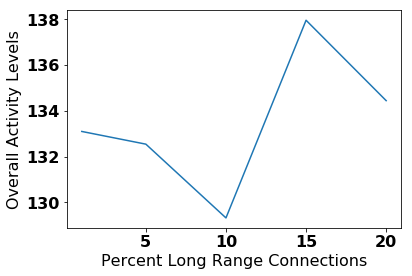

In [189]:
pct_sw = [0,1,5,10,15,20]
vw = np.arange(1,len(pct_sw)-1)
plt.plot(pct_sw[1:],act[1:])
plt.ylabel('Overall Activity Levels')
plt.xlabel('Percent Long Range Connections')
plt.show()

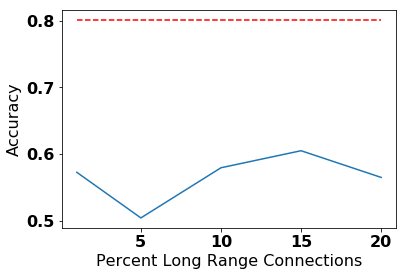

In [190]:
plt.plot(pct_sw[1:],acc_rec[1:])
plt.plot(pct_sw[1:6:4],[acc_og, acc_og],'r--')
plt.ylabel('Accuracy')
plt.xlabel('Percent Long Range Connections')
plt.show()

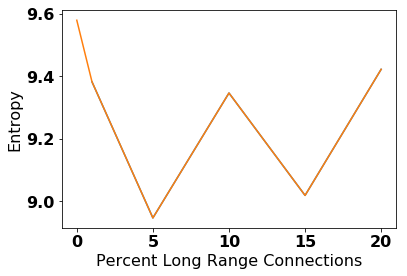

In [191]:
pct_sw = [0,1,5,10,15,20]
vw = np.arange(1,len(pct_sw)-1)
plt.plot(pct_sw[1:],ent[1:])
plt.ylabel('Entropy')
plt.plot(pct_sw,ent)
plt.xlabel('Percent Long Range Connections')
plt.show()

In [206]:
fn2 = 'bottle_weights.p'
dat2 = pickle.load(open(fn2))


my_nets2 = [i for i in dat2[0]]
nnets = len(my_nets2)

ent2 = np.zeros(nnets)
act2 = np.zeros(nnets)
acc_rec2 = np.zeros(nnets)

for i in range(nnets):
    ent2[i],act2[i],acc_og,acc_rec2[i] = quick_eval_2(my_nets2[i])

/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


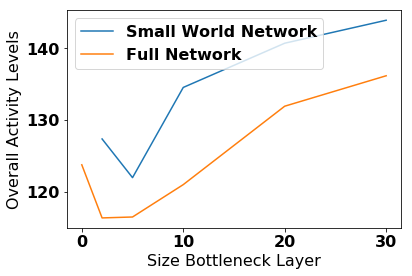

In [243]:
dat2[1]
sw_pct = np.array([0,2,2,5,5,10,10,20,20,30,30])
is_SW = np.array([0,0,1,0,1,0,1,0,1,0,1])==1
#is_SW = [is_SW]==1
not_SW = is_SW==0
#not_SW[0] = 0

sw_pct[is_SW]
plt.plot(sw_pct[is_SW],act2[is_SW],label='Small World Network')
plt.plot(sw_pct[not_SW],act2[not_SW],label='Full Network')
plt.ylabel('Overall Activity Levels')
plt.xlabel('Size Bottleneck Layer')
plt.legend()
plt.show()

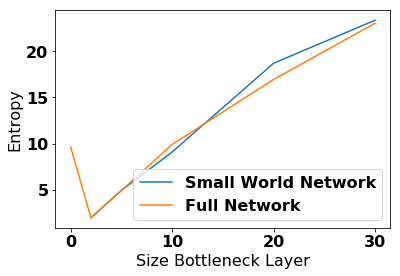

In [244]:
plt.plot(sw_pct[is_SW],ent2[is_SW],label='Small World Network')
plt.plot(sw_pct[not_SW],ent2[not_SW],label='Full Network')
plt.ylabel('Entropy')
plt.xlabel('Size Bottleneck Layer')
plt.legend()
plt.show()

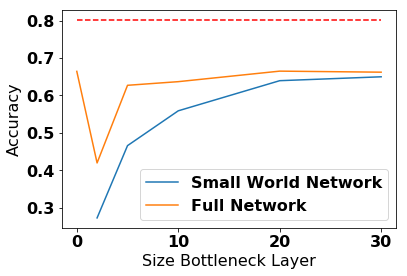

In [248]:
plt.plot(sw_pct[is_SW],acc_rec2[is_SW],label='Small World Network')
plt.plot(sw_pct[not_SW],acc_rec2[not_SW],label='Full Network')
plt.plot([0, 30],[acc_og, acc_og],'r--')
plt.ylabel('Accuracy')
plt.xlabel('Size Bottleneck Layer')
plt.legend()
plt.show()

('Entropy:', 9.6658814346959812, 'Activity:', 134.75192292732353)
('Acc Reconstructed:', 0.5988, 'Acc OG:', 0.8007)


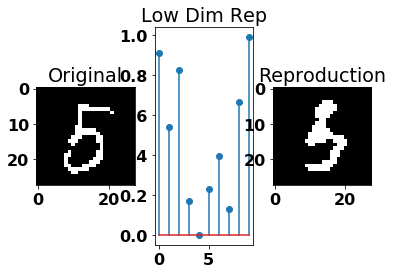

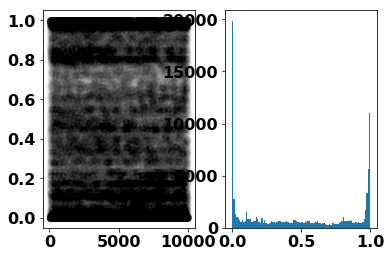

In [239]:
quick_eval(net_ae,True)    

In [13]:
quick_eval(net_ae_we0,True)    

NameError: name 'net_ae_we0' is not defined

/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


('Entropy:', 0.0, 'Activity:', 49.934523513459908)
('Acc Reconstructed:', 0.1028, 'Acc OG:', 8277)


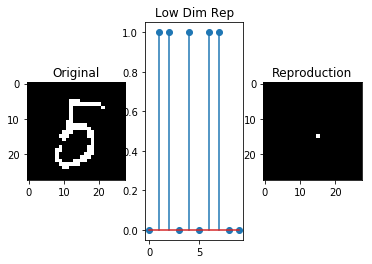

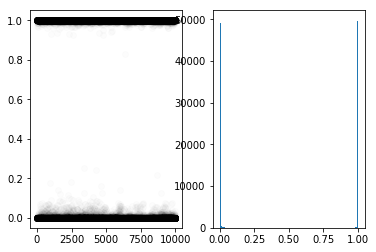

In [66]:
quick_eval(net_ae_we01,True)   

/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


('Entropy:', 0.44968221312250012, 'Activity:', 36.197241706468972)
('Acc Reconstructed:', 0.1028, 'Acc OG:', 8277)


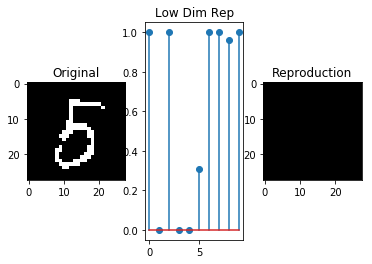

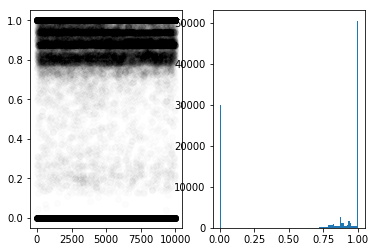

In [67]:
quick_eval(net_ae_we10,True)   

/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/Users/sheehantc/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


('Entropy:', 0.0, 'Activity:', 128.23522997720238)
('Acc Reconstructed:', 0.1028, 'Acc OG:', 8277)


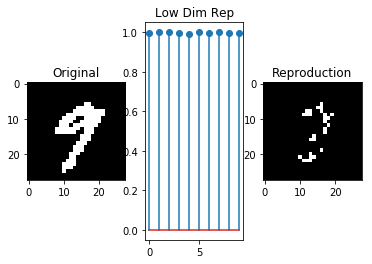

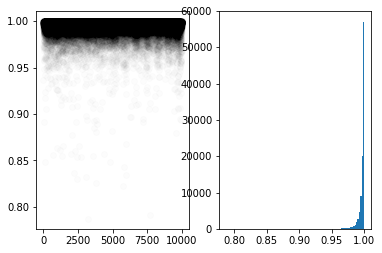

In [56]:
quick_eval(net_ae_we0001,True)   

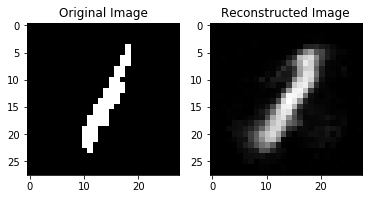

In [24]:
# TO DO
# Add Noise
# measure stats in function
#  -acc
#  -entropy
# Add energy use penalty


# compute entropy

/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/home/AD/tsheehan/anaconda3/envs/mne/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


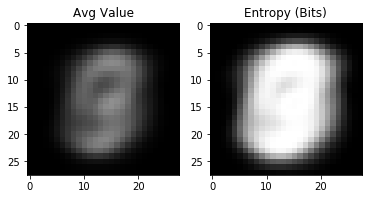

In [451]:
# now that it is binary simply compute 
foo = training_data
x = [i[0] for i in training_data]
x_avg = np.mean(x,0)
x_ent = bin_ent(x_avg)
plt.subplot(1,2,1)
plt.imshow(np.reshape(x_avg,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Avg Value')
plt.subplot(1,2,2)
plt.imshow(np.reshape(x_ent,(28,28)),vmin=0, vmax=1,cmap='gray')
plt.title('Entropy (Bits)')
plt.show()

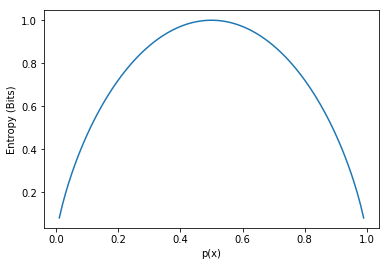

In [20]:
x = np.arange(0.01,1,.01)
plt.plot(x,bin_ent(x))
plt.xlabel('p(x)')
plt.ylabel('Entropy (Bits)')
plt.show()

In [93]:
foo = list(map(lambda x:(x>.5)*1,t_in))

In [854]:
net_size = [28*28,30,5,30,28*28]
plt.title('Reconstructed Image')
import random
from scipy.spatial.distance import cdist 
#for n in range(len(net_size)-1):
n = 0

rad1 = (np.arange(net_size[n],dtype=float)/net_size[n])*2*np.pi
rad2 = (np.arange(net_size[n+1],dtype=float)/net_size[n+1])*2*np.pi

def xy_dist_rad(rad1,rad2):
 
    return mat
def gen_weights_local(nx,ny,tol,add_rand=None):
    rad1 = (np.arange(nx,dtype=float)/nx)*2*np.pi
    rad2 = (np.arange(ny,dtype=float)/ny)*2*np.pi
    loc1 = np.transpose(np.array([np.cos(rad1),np.sin(rad1)]))
    loc2 = np.transpose(np.array([np.cos(rad2),np.sin(rad2)]))
    mat = cdist(loc2,loc1)
    in_thresh = mat<tol
    norm = np.mean(in_thresh)*np.sqrt(nx)
    if add_rand:
        long_cnx = add_rand_con(nx,ny,add_rand)
        in_thresh[long_cnx] = 1
    wts = np.random.randn(ny, nx)/norm
    wts[in_thresh==0] = 0
    return wts
def add_rand_con(nx,ny,pct):
    #nx,ny,pct = 20,5,10
    pool = np.arange(nx*ny)
    cnx = np.array(random.sample(pool,nx*ny*pct/100))
    p_x = cnx%nx
    p_y = cnx//nx
    new_wts = np.zeros((ny,nx))==1
    new_wts[p_y,p_x] = True
    return new_wts

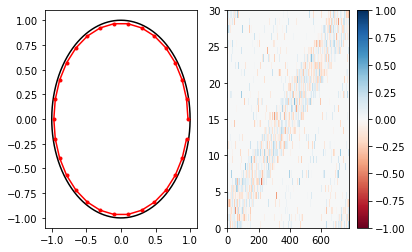

In [855]:
tol = .8
wts = gen_weights_local(net_size[0],net_size[1],tol,add_rand = 10)

plt.subplot(1,2,1)
plt.plot(np.cos(this_layer),np.sin(this_layer),'k',markersize=1)
plt.plot(np.cos(next_layer)*.97,np.sin(next_layer)*.97,'r.-')
plt.subplot(1,2,2)
plt.pcolormesh(wts,cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()
plt.show()


In [78]:
# def process_weights
loc = 'blah.p'
foo = pickle.load(open(loc))

In [82]:
np.shape(foo[1])
np.shape(foo[0][0])

(2, 4)

In [80]:
foo[1]

['OG', 'Bottle:5', 'Tim']